PV Data Columns: ['datetime', 'sensor_id', 'power_avg_kw']

Meter Data Columns: ['datetime', 'meter_name', 'mean']


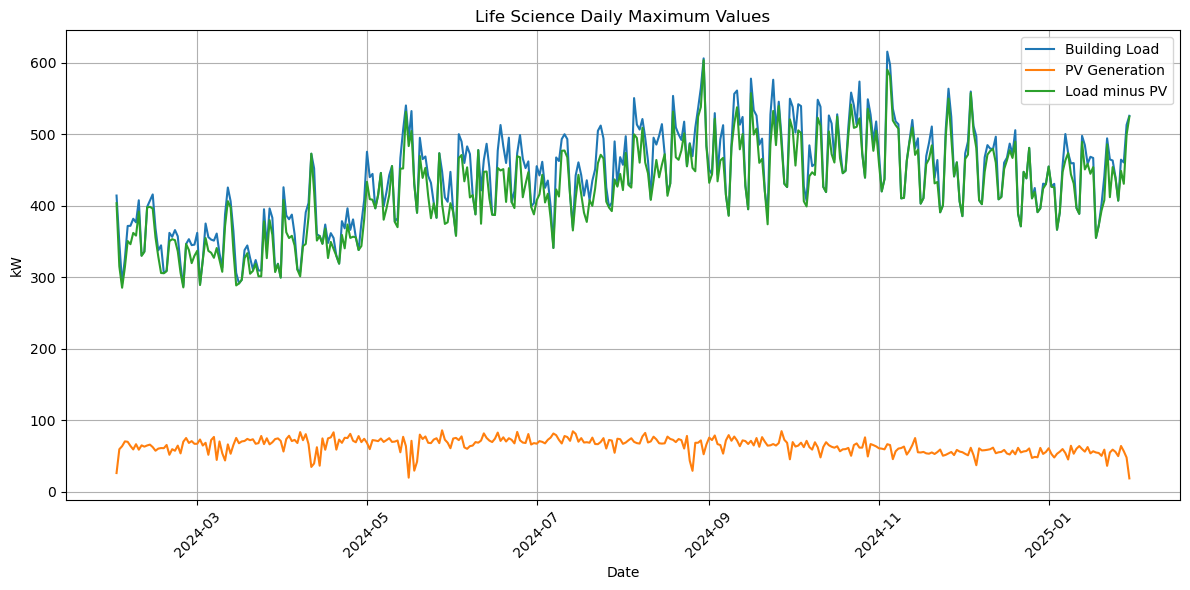

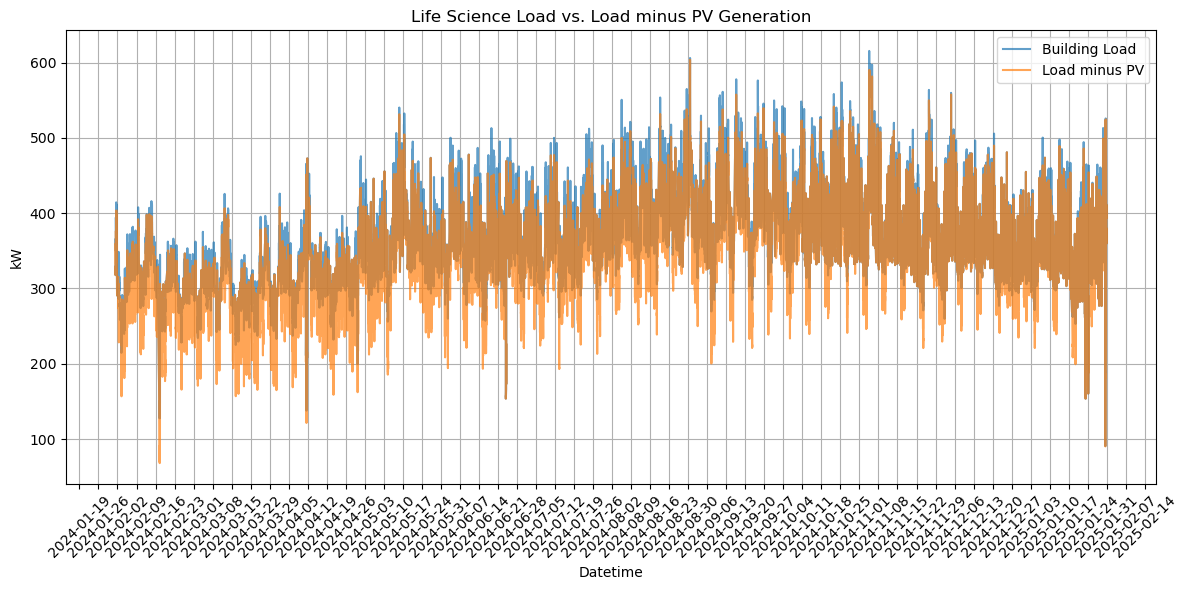

In [27]:
#NOT FINSIHED STILL NEED TO CREATE SEPERATE FUCNTION FILES


from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# loading and reading meter data
pv_path = Path('life_science_pv.csv') 
with pv_path.open('r') as file:
    pv_df = pd.read_csv(file)
    print("PV Data Columns:", pv_df.columns.tolist())
pv_df['datetime'] = pd.to_datetime(pv_df['datetime'])
pv_df = pv_df.sort_values('datetime')
meter_path = Path('life_sciences_msb1_main.csv') 
with meter_path.open('r') as file:
    meter_df = pd.read_csv(file)
    print("\nMeter Data Columns:", meter_df.columns.tolist())
meter_df['datetime'] = pd.to_datetime(meter_df['datetime'])
meter_df = meter_df.sort_values('datetime')

# making one dataset
combined_df = pd.merge(meter_df, pv_df, on='datetime', how='inner')
building_load_col = 'mean'
pv_gen_col = 'power_avg_kw' 

# load - pv generation
combined_df['building_load_minus_pv'] = combined_df[building_load_col] - combined_df[pv_gen_col]

# daily max values
combined_df['date'] = combined_df['datetime'].dt.date
daily_max = combined_df.groupby('date').agg({
    building_load_col: 'max',
    pv_gen_col: 'max',
    'building_load_minus_pv': 'max'
}).rename(columns={
    building_load_col: 'daily_max_load',
    pv_gen_col: 'daily_max_pv',
    'building_load_minus_pv': 'daily_max_load_minus_pv'
}).reset_index()

# add daily max to combined dataframe
combined_df = pd.merge(combined_df, daily_max, on='date', how='left')

# Plot 1: Daily maximum values comparison
plt.figure(figsize=(12, 6))
plt.plot(daily_max['date'], daily_max['daily_max_load'], label='Building Load')
plt.plot(daily_max['date'], daily_max['daily_max_pv'], label='PV Generation')
plt.plot(daily_max['date'], daily_max['daily_max_load_minus_pv'], label='Load minus PV')

plt.title('Life Science Daily Maximum Values')
plt.xlabel('Date')
plt.ylabel('kW')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 2: Time series comparison
plt.figure(figsize=(12, 6))
plt.plot(combined_df['datetime'], combined_df[building_load_col], label='Building Load', alpha=0.7)
plt.plot(combined_df['datetime'], combined_df['building_load_minus_pv'], label='Load minus PV', alpha=0.7)

plt.title('Life Science Load vs. Load minus PV Generation')
plt.xlabel('Datetime')
plt.ylabel('kW')
plt.legend()
plt.grid(True)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
